In [1]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]

# 构建词汇表并打印
sentences_list = ' '.join(sentences).split()
word_list = list(set(sentences_list))
# 创建字典
# word -> index
word_to_idx = {word: index for index,word in enumerate(word_list)}
# index -> word
idx_to_word = {index: word for index,word in enumerate(word_list)}
voc_size = len(idx_to_word)
print(len(word_list))
print(word_to_idx)
print(idx_to_word)

9
{'Mazong': 0, 'Student': 1, 'Teacher': 2, 'Xiaobing': 3, 'Niuzong': 4, 'Boss': 5, 'is': 6, 'Kage': 7, 'Xiaoxue': 8}
{0: 'Mazong', 1: 'Student', 2: 'Teacher', 3: 'Xiaobing', 4: 'Niuzong', 5: 'Boss', 6: 'is', 7: 'Kage', 8: 'Xiaoxue'}


In [2]:
# 生成训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = [] # 初始化数据
    for sentence in sentences: # 遍历句子
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            # 需要获取的词汇长度: window_sise + idx + window_size
            for neighbor in sentence[max(idx - window_size, 0) : min(idx + window_size, len(sentence))]:
                if neighbor != word:
                    data.append((neighbor, word))
    return data

# Skip-Grim创建训练数据 (neighbor, word) = (target, input)
train_set = create_skipgram_dataset(sentences=sentences)
print(train_set[0: len(train_set)])

[('is', 'Kage'), ('Kage', 'is'), ('Teacher', 'is'), ('Kage', 'Teacher'), ('is', 'Teacher'), ('is', 'Mazong'), ('Mazong', 'is'), ('Boss', 'is'), ('Mazong', 'Boss'), ('is', 'Boss'), ('is', 'Niuzong'), ('Niuzong', 'is'), ('Boss', 'is'), ('Niuzong', 'Boss'), ('is', 'Boss'), ('is', 'Xiaobing'), ('Xiaobing', 'is'), ('Student', 'is'), ('Xiaobing', 'Student'), ('is', 'Student'), ('is', 'Xiaoxue'), ('Xiaoxue', 'is'), ('Student', 'is'), ('Xiaoxue', 'Student'), ('is', 'Student')]


In [5]:
# 通过继承nn.Module类来实现SkipGram类
import torch.nn as nn # 导入神经网络库
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        """
        embedding_size为词向量维度
        """
        super(SkipGram, self).__init__()
        # 输入(ont-hot)到嵌入层 math:`y = xA^T + b`
        self.input_to_hidden = nn.Embedding(voc_size, embedding_size) 
        # 从嵌入层到输出层(等于词汇表大小)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size)
    
    def forward(self, X): # 前向传播 X形状为(batch_size, voc_size)
        embedding = self.input_to_hidden(X) # (batch_size, embedding_size)
        output = self.hidden_to_output(embedding) # (batch_size, voc_size)
        return output

embedding_size = 2 # 词向量的维度, 设置为2是为了后面便于展示相关性, 通常为几百。其实通过t-SNE对高维数据降维可视化
# 实例化模型
skipgram_model = SkipGram(voc_size, embedding_size)
print("模型结构:", skipgram_model)

模型结构: SkipGram(
  (input_to_hidden): Embedding(9, 2)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=True)
)


Epoch: 100, Loss: 2.038466730117798
Epoch: 200, Loss: 1.9205970120429994
Epoch: 300, Loss: 1.8464883685112
Epoch: 400, Loss: 1.7808708214759827
Epoch: 500, Loss: 1.71323392868042
Epoch: 600, Loss: 1.6446639430522918
Epoch: 700, Loss: 1.581173424720764
Epoch: 800, Loss: 1.5271625518798828
Epoch: 900, Loss: 1.4830488020181656
Epoch: 1000, Loss: 1.446930668950081


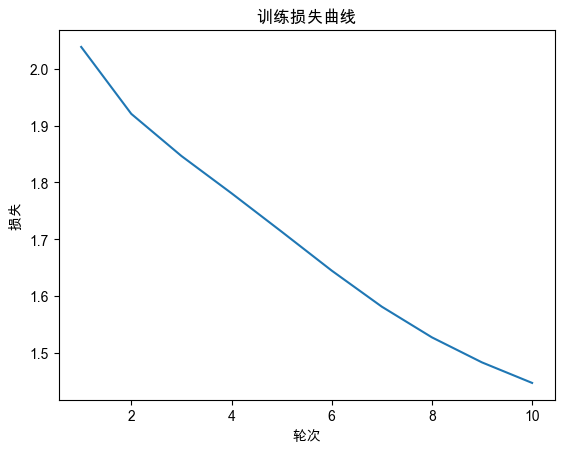

In [6]:
# 设置一些模型训练的参数
import torch
learning_rate = 0.001 # 设置学习率
epochs = 1000 # 训练轮次
criterion = nn.CrossEntropyLoss() # 定义交叉熵损失函数
import torch.optim as optim
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate) # 梯度下降优化器
# 开始训练
loss_values = [] # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0
    for context, target in train_set:
        X = torch.tensor([word_to_idx[target]], dtype=torch.long) 
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        y_pred = skipgram_model(X) # 得到预测值
        loss = criterion(y_pred, y_true) # 损失函数
        loss_sum += loss.item()
        optimizer.zero_grad() # 清空梯度
        loss.backward() # 误差反向传播, 主要是为了获得梯度
        optimizer.step() # 更新参数
    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(train_set)}")  
        loss_values.append(loss_sum / len(train_set))

# 绘制损失函数曲线
import matplotlib.pyplot as plt
# 绘制二维词向量图
plt.rcParams["font.family"]=['Arial Unicode MS'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [8]:
# 打印词嵌入向量
for word,idx in word_to_idx.items():
    print(f"{word}:{skipgram_model.input_to_hidden.weight[idx].detach().numpy()}")

Mazong:[-0.378952   1.1144148]
Student:[-1.5829555  2.3961875]
Teacher:[-0.5760074  1.0133035]
Xiaobing:[0.25490108 1.5309372 ]
Niuzong:[0.21221615 0.50760174]
Boss:[1.3386612  0.36076048]
is:[-0.32547382 -0.8626813 ]
Kage:[0.19888775 0.966512  ]
Xiaoxue:[0.7833309 0.4951613]
